In [6]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

from models import SoftIntroVAE
from dataset import UkiyoE, load_labels

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from umap import UMAP 
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
ch = 3
z_dim = 64
image_size = 64
channels = [64, 128, 256, 512]
batch_size = 64

In [8]:
beta_kl = 0.5
beta_neg = 512.0
beta_rec = 0.5

In [9]:
model_name = f"ukiyo_e64_soft_intro_betas_{beta_kl}_{beta_neg}_{beta_rec}_zdim_{z_dim}_model_epoch_249_iter_65250.pth"
model_name = "ukiyo_e64_soft_intro_betas_0.75_512.0_0.5_zdim_64_res_adam_model_epoch_249_iter_65250.pth"
model_path = os.path.expanduser("~/ukiyo_e_project/saves/" + model_name)
print(model_name)

data_dir = os.path.expanduser("~/arc-ukiyoe-faces/scratch")
image_dir = data_dir + "/arc_extracted_face_images"

ukiyo_e64_soft_intro_betas_0.75_512.0_0.5_zdim_64_res_adam_model_epoch_249_iter_65250.pth


In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

model = SoftIntroVAE(arch="res",cdim=ch, zdim=z_dim, channels=channels, image_size=image_size)
model.to(device)

epoch, state_dict = torch.load(model_path, map_location=device).values()
model.load_state_dict(state_dict)
model.eval()

conv shape:  torch.Size([512, 4, 4])
num fc features:  8192


SoftIntroVAE(
  (encoder): Encoder(
    (main): Sequential(
      (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
      (3): AvgPool2d(kernel_size=2, stride=2, padding=0)
      (res_in_32): ResidualBlock(
        (conv_expand): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): LeakyReLU(negative_slope=0.2, inplace=True)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): LeakyReLU(negative_slope=0.2, inplace=True)
      )
      (down_to_16): AvgPool2

In [11]:
train_set = UkiyoE(image_dir, load_labels(), "Painter", resize=image_size)
train_data_loader = DataLoader(train_set, batch_size=batch_size, shuffle=False, num_workers=1)

output_shape = (len(train_set), z_dim)
encoder_output = np.ndarray(shape=output_shape, dtype=np.float16)

In [12]:
count = 0
label_output = np.array([])
with torch.no_grad(), tqdm(iterable=train_data_loader) as tbatch:
    for x_batch, y_batch in tbatch:
        mu, logvar = model.encode(x_batch.to(device))
        label_output = np.append(label_output, list(y_batch))
        encoder_output[count : count + len(y_batch)] = mu.cpu().numpy()
        count += len(y_batch)
        if count >= len(train_set):
            print()
            print("Done")
            break

100%|█████████▉| 260/261 [00:34<00:00,  7.49it/s]


Done


In [13]:
top_n = 3
top_artists = pd.Series(label_output).value_counts().drop(index="nan")[0:top_n]
top_artist_mask = np.isin(label_output, top_artists.index)

top_labels = label_output[top_artist_mask]
top_encoder_output = encoder_output[top_artist_mask]

print(top_labels.shape, top_encoder_output.shape)

(3155,) (3155, 64)


In [14]:
artists = dict(
    Hirosada = "広貞",
    Kogyo = "耕漁",
    # Yoshitaki = "芳滝",
    Kunichika = "国周",
)
selected_artist_mask = np.isin(label_output, list(artists.values()))

selected_labels = label_output[selected_artist_mask]
selected_encoder_output = encoder_output[selected_artist_mask]

pd.Series(selected_labels).value_counts()

国周    706
広貞    390
耕漁    353
dtype: int64

In [15]:
le = LabelEncoder()
c = le.fit_transform(selected_labels)

def plot_2d(reduced_activations, x_col, y_col):
    fig, ax = plt.subplots()
    scatter = ax.scatter(x=reduced_activations[x_col], y=reduced_activations[y_col], c=c, cmap="Set1", alpha=0.5)
    ax.set_xlabel(x_col)
    ax.set_ylabel(y_col)
    ax.set_title(x_col.split("-")[0])
    
    handles, labels = scatter.legend_elements()
    artists_inv = {v:k for k,v in artists.items()}
    labels = [artists_inv[f] for f in le.inverse_transform(list(range(len(artists))))]
    legend = ax.legend(handles, labels, loc="upper right", title="Artist")
    ax.add_artist(legend)
    fig.show()

### Apply PCA

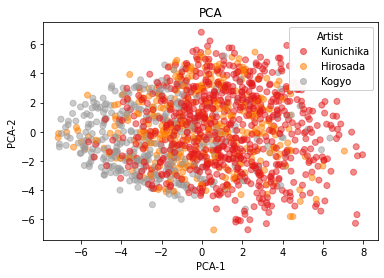

In [16]:
pca = PCA(n_components=2)
reduced_activations = pd.DataFrame(pca.fit_transform(selected_encoder_output), columns=["PCA-1", "PCA-2"])
reduced_activations["label"] = selected_labels
plot_2d(reduced_activations, "PCA-1", "PCA-2")

### Apply t-SNE

/home/ubuntu/.conda/envs/pytorch/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


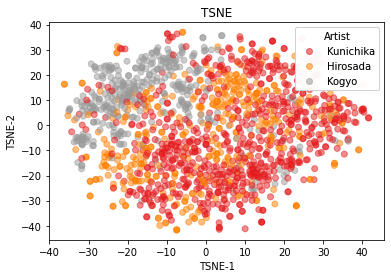

In [17]:
tsne = TSNE(n_components=2, perplexity=40.0, learning_rate='auto', init='pca')
reduced_activations = pd.DataFrame(tsne.fit_transform(selected_encoder_output), columns=["TSNE-1", "TSNE-2"])
reduced_activations["label"] = selected_labels
plot_2d(reduced_activations, "TSNE-1", "TSNE-2")

### Apply Linear discriminant analysis

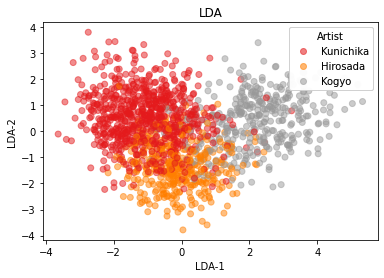

In [18]:
lda = LinearDiscriminantAnalysis(n_components=2)
reduced_activations = pd.DataFrame(lda.fit_transform(selected_encoder_output, selected_labels), columns=["LDA-1", "LDA-2"])
reduced_activations["label"] = selected_labels
plot_2d(reduced_activations, "LDA-1", "LDA-2")

### Apply UMAP

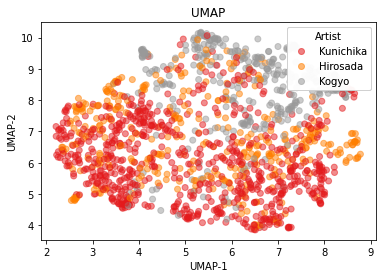

In [19]:
umap = UMAP(n_components=2)
reduced_activations = pd.DataFrame(umap.fit_transform(selected_encoder_output), columns=["UMAP-1", "UMAP-2"])
reduced_activations["label"] = selected_labels
plot_2d(reduced_activations, "UMAP-1", "UMAP-2")

In [20]:
def decode_lerp(start, end, weight):
    z = torch.lerp(start, end, weight)
    return torch.clamp(model.decode(z).squeeze(), 0.0, 1.0)

## Plot Dimensions

<Figure size 432x288 with 0 Axes>

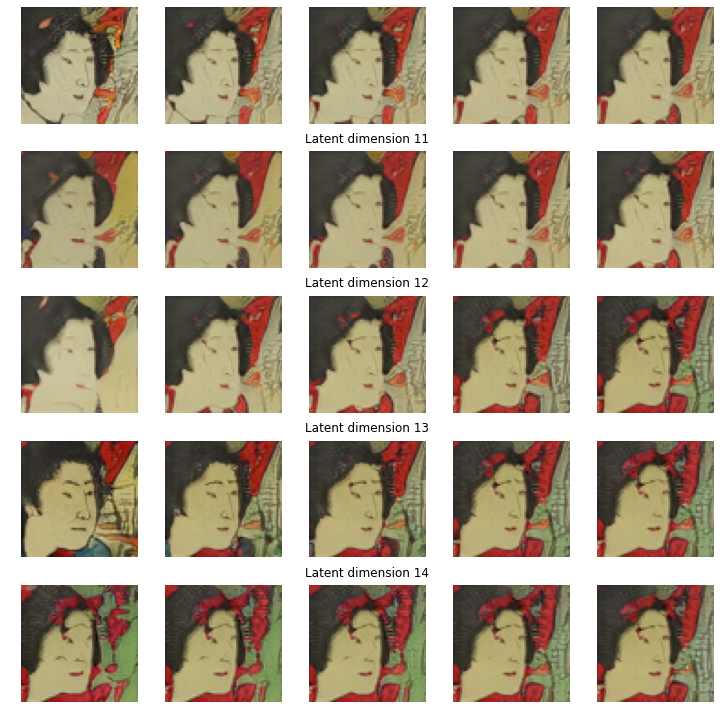

In [25]:
def plot_latent_dim(model, i, fig, axs, z_sample=None):
    if z_sample is None:
        z_sample = np.full((1, z_dim), 0.0, dtype=np.float32)
    for v, ax in zip([-5.0, -2.5, -1.5, 0.0, 1.5, 2.5, 5.0], axs):
        z_sample[0,i] = v
        x_decoded = model.decode(torch.from_numpy(z_sample).to(device)).squeeze()
        img = torch.clamp(x_decoded, 0.0, 1.0)
        img = img.cpu().numpy().transpose((1,2,0))
        ax.set_axis_off()
        ax.imshow(img)
        # ax.set_title(f'{v}')


def plot_latent_space(model, nrows=5, z_sample=None, start=0):
    fig = plt.figure(constrained_layout=True, figsize=(10,10))
    subfigs = fig.subfigures(nrows=nrows, ncols=1)
    for row, subfig in zip(range(start, start+nrows), subfigs):    
        subfig.suptitle(f'Latent dimension {row}')

        axs = subfig.subplots(nrows=1, ncols=5)
        plot_latent_dim(model, row, subfig, axs, z_sample)
    fig.show()


plt.tight_layout()
with torch.no_grad():
    z = selected_encoder_output[0].reshape((1, z_dim)).astype(np.float32)
    plot_latent_space(model, z_sample=z, start=10, nrows=5)

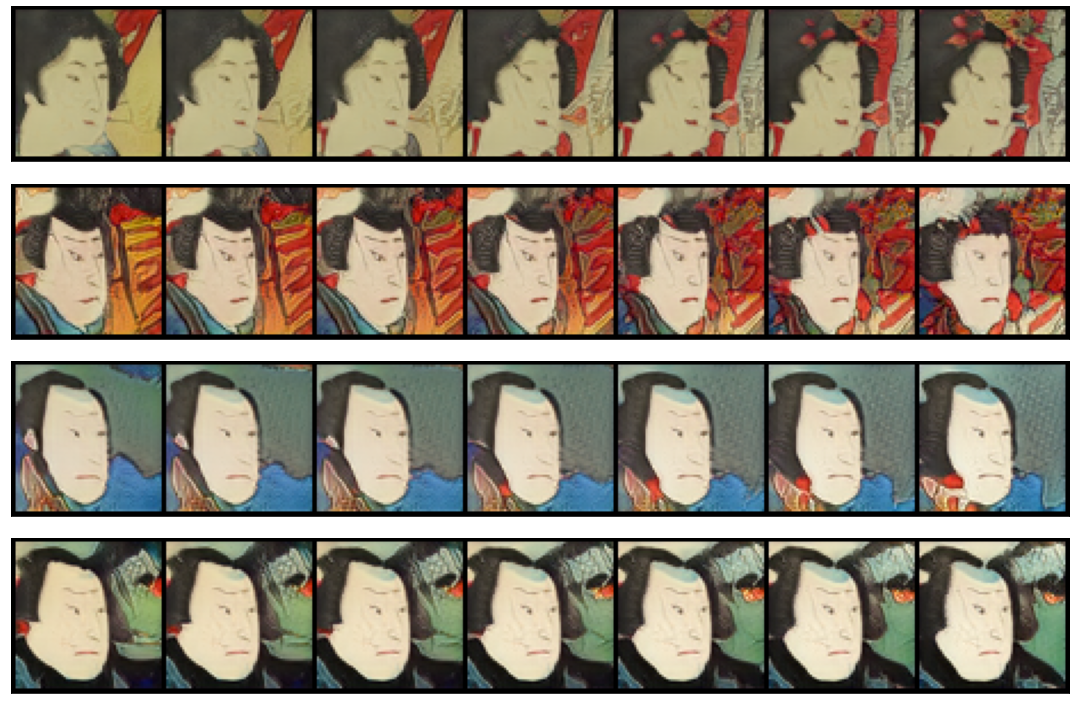

In [50]:

def plot_dimension_change(ax, img_idx, dim):
    z_sample = selected_encoder_output[img_idx].reshape((1, z_dim)).astype(np.float32)
    decode_list= []
    for v in [-4.0, -2.5, -1.5, 0.0, 1.5, 2.5, 4.0]:
        z_sample[0, dim] = v
        x_decoded = torch.clamp(model.decode(torch.from_numpy(z_sample).to(device)).squeeze(), 0.0, 1.0)
        decode_list.append(x_decoded.cpu())
    grid_img = make_grid(decode_list, nrow=len(decode_list))
    ax.imshow(grid_img.permute(1, 2, 0))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

fig, axs = plt.subplots(ncols=1, nrows=4, figsize=(15,10))
idxs = [0, 1, 4, 13]
for i, ax in zip(idxs, axs):
    plot_dimension_change(ax, i, 13)

plt.tight_layout()
plt.savefig("documentation/dim_interpolation.png", format="png", transparent=True, dpi=250, pad_inches=0)
fig.show()

## Plot interpolations

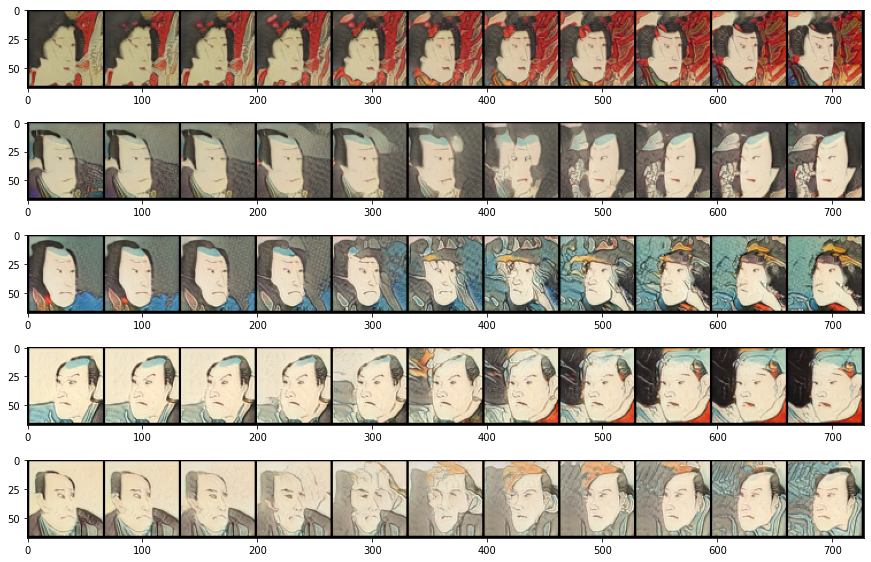

In [22]:
n_interp= 5
fig, ax = plt.subplots(ncols=1, nrows=n_interp, figsize=(15,10))

for i in range(n_interp):
    start = torch.Tensor(encoder_output[2*i].reshape(1,z_dim)).to(device)
    end = torch.Tensor(encoder_output[2*i+1].reshape(1,z_dim)).to(device)

    lerp_list = [decode_lerp(start, end, j).cpu() for j in np.linspace(0.0, 1.0, 11)]
    grid_img = make_grid(lerp_list, nrow=len(lerp_list))

    ax[i].imshow(grid_img.permute(1, 2, 0))
fig.show()